<a href="https://colab.research.google.com/github/ucb-datalab/course_materials_fall2024/blob/main/lectures/Lecture20_lab3_cnn/03_CNNs_pytorch.ipynb" target="_blank" rel="nofollow">
    <img src="figs/colab-badge.svg" alt="Open In Colab" />
</a>

In [138]:
# do this step below to get lightning, lightning bolts, etc.
# !pip install lightning-bolts torchvision torchsummary

# Classification with pytorch (Lightning)

*AY 128/256 (UC Berkeley, 2018-2024)*

Here we'll work with pytorch lightning; its a wrapper around pytorch that provides a little more structure to the code.  There's no need to use it for this lab, though you're welcome to do so! 

Let's now explore classification, on images. Let's introduce the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist#labels) dataset: 70k small (28$\times$28) images of 10 different types of clothing.

<img src="https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true" width="80%">

Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

let's define the labels in code:

In [1]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [63]:
import datetime, os
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt

# from IPython.external import mathjax

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, ModelSummary
from pytorch_lightning.loggers import CSVLogger

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

# use a GPU or MPS (Mac) if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = "mps"

print("pytorch version:", torch.__version__)
print("device:", device)

pytorch version: 2.3.1
device: mps


Let's get the training and testing data 

**note that I've included the .csv files locally so you don't have to download these as written below**

In [1]:
%%bash
wget -q "https://github.com/fpleoni/fashion_mnist/blob/master/fashion-mnist_train.csv?raw=true" --output-document=fashion-mnist_train.csv
wget -q "https://github.com/fpleoni/fashion_mnist/blob/master/fashion-mnist_test.csv?raw=true" --output-document=fashion-mnist_test.csv
gzip fashion-mnist_train.csv
gzip fashion-mnist_test.csv

In [5]:
train_csv = pd.read_csv("./fashion-mnist_train.csv.gz")
test_csv = pd.read_csv("./fashion-mnist_test.csv.gz")

In [7]:
%%writefile fashion_dataset.py

import numpy as np
from torch.utils.data import Dataset

class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

Overwriting fashion_dataset.py


In [8]:
from fashion_dataset import FashionDataset

In [10]:
batch_size = 128

# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, persistent_workers=True)
test_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, persistent_workers=True)

In [11]:
next(iter(train_loader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [12]:
len(train_set)

60000

In [13]:
type(train_set[0])

tuple

In [14]:
train_set[0][0].shape

torch.Size([1, 28, 28])

In [15]:
train_set[0][1]

2

'Pullover'

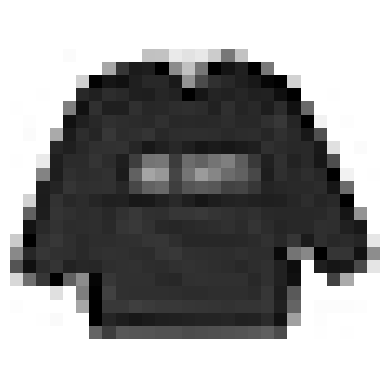

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

image, label = train_set[0]
plt.axis('off')

plt.imshow(image.squeeze(), cmap=plt.cm.gray_r, interpolation='nearest')
output_label(label)

To learn a model to predict the class of a given image, we could treat this 28$\times$28 image as 1d input, like a stellar spectrum:

Text(0.5, 0, '1D pixel index')

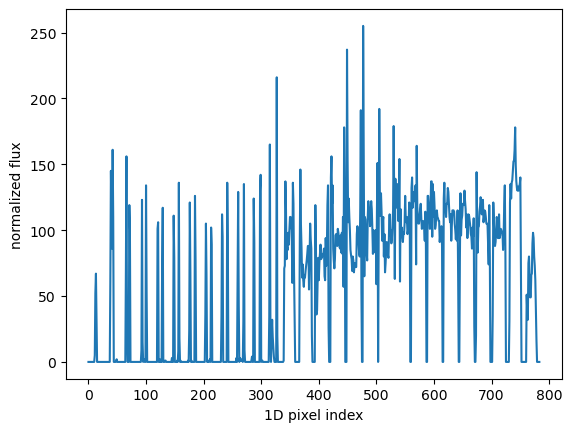

In [17]:
ind=20
_ = plt.plot(train_set[ind][0].numpy().reshape(-1))
plt.ylabel("normalized flux")
plt.xlabel("1D pixel index")

But this *clearly* jumbles the inherent spatial structure and local correlations found in natural images. Using just Dense layers in a NN we'd effectively be asking the network to learn these correlations.

## Convolutional Neural Nets (ConvNets or CNNs)

NNs built for images (or more generally, inputs with spatial structure).

### Key Ideas: 
  - layers see only parts of each image (effectively all other weights are zero).
  - some layers do simple operations on previous layers to reduce dimensionality (e.g., take the largest value in a a 3x3 range)
  - "Every Layer has a simple API: It transforms an input 3D volume to an output 3D volume with some differentiable function that may or may not have parameters."
 
<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg">

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg">

"An example input volume in red (e.g. a 32x32x3 CIFAR-10 image), and an example volume of neurons in the first Convolutional layer. Each neuron in the convolutional layer is connected only to a local region in the input volume spatially, but to the full depth (i.e. all color channels). Note, there are multiple neurons (5 in this example) along the depth, all looking at the same region in the input - see discussion of depth columns in text below. "

cf. http://cs231n.github.io/convolutional-networks/

<img src="figs/f2.png">
Source: http://www.nature.com/nature/journal/v521/n7553/fig_tab/nature14539_F2.html

### Filter banks

  http://setosa.io/ev/image-kernels/

### Pooling

<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" width="40%">
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width="40%">
Source: http://cs231n.github.io/convolutional-networks/

We want our output predictions to look like a "probability" of belonging to one of the 10 classes. And, importantly, we'd like to make sure that the probability over all classes sums to unity. One way to do this is to scale the outputs of the last layer using a [`softmax`](https://en.wikipedia.org/wiki/Softmax_function):

$$
{\rm softmax}(\vec s) = \frac{e^{s_i}}{\sum_i e^{s_i}}
$$

So if the (unnormalized) prediction from am NN for an image is:

In [18]:
s = np.random.normal(size=(10,))
s

array([ 1.15241543, -0.3097689 ,  0.05500873, -2.86801135, -0.05283703,
       -1.56963952, -1.28530217, -1.70183899,  0.59135653,  0.29484204])

Then the softmax scaling gives us:

In [19]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

print(softmax(s))
np.testing.assert_almost_equal(softmax(s).sum(), 1.0)

[0.32377971 0.07502933 0.10805676 0.00581033 0.0970097  0.02128512
 0.0282854  0.01864931 0.18475017 0.13734417]


In [20]:
from scipy.special import softmax as sp_softmax
sp_softmax(s)

array([0.32377971, 0.07502933, 0.10805676, 0.00581033, 0.0970097 ,
       0.02128512, 0.0282854 , 0.01864931, 0.18475017, 0.13734417])

We'll use the "categorical cross-entropy" loss:

<img src="https://gombru.github.io/assets/cross_entropy_loss/softmax_CE_pipeline.png">
Source: https://gombru.github.io/2018/05/23/cross_entropy_loss/

In [21]:

def to_categorical(y, num_classes):
    """ 
    Converts a class vector (integers) to a binary class matrix.

    Args:
        y: A tensor of class indices (integers).
        num_classes: The total number of classes.

    Returns:
        A binary matrix representation of the input.
    """
    return torch.eye(num_classes)[y]

nb_classes = 10
train_label = torch.tensor([train_set[i][1] for i in range(10)])
train_label

tensor([2, 9, 6, 0, 3, 4, 4, 5, 4, 8])

In [22]:
y_train = to_categorical(train_label, nb_classes)
y_train

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [23]:
# perfect match ... use a small ϵ to avoid taking log(0) since lim x log x -> 0 as x->0
print("loss with a perfect match:", -(y_train[0].double() @ np.log(y_train[0].double() + 1e-16)).numpy())
print("loss with a predicted match:", -(y_train[0].double() @ np.log(softmax(s) + 1e-16)).numpy())

loss with a perfect match: -0.0
loss with a predicted match: 2.2250985963459473


## Building a CNN

In [24]:
import pytorch_lightning as pl

In [92]:
class mycnn(pl.LightningModule):

    def __init__(self):
        super().__init__()

        # set this to an example input size to the see a summary
        # see https://pytorch-lightning.readthedocs.io/en/latest/common/debugging.html
        self._example_input_array = torch.randn((1, 1, 28, 28))

        # define the layers here
        # Conv2d(in_channels, out_channels, kernel_size)
        # see https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            
            # see https://github.com/sksq96/pytorch-summary/issues/55#issuecomment-471844028
            # to understand why pytorch and keras differ here
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
        )
        
        self.fc1=torch.nn.Linear(1152, 32)
        self.fc2=torch.nn.Linear(32, nb_classes)

        # Negative Log Liklihood Loss
        # see https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
        self.loss = nn.NLLLoss()

        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x=torch.relu(self.fc1(x))
        x=F.log_softmax(self.fc2(x), dim=-1)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.75,
            patience=2,
            min_lr=1e-6,
            verbose=True
        )
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_accuracy"}
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())
        return loss
    
    def _evaluate(self, batch, batch_idx, stage=None):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=-1)
        acc = accuracy(preds, y, task="multiclass", num_classes=nb_classes)

        if stage:
            self.log(f'{stage}_loss', loss, prog_bar=True)
            self.log(f'{stage}_accuracy', acc, prog_bar=True)
        if stage == "val":
            self.val_losses.append(loss.item())  # Track validation loss
            self.val_accuracies.append(acc.item())  # Track validation accuracy

        return loss, acc
    
    def validation_step(self, batch, batch_idx):
        return self._evaluate(batch, batch_idx, 'val')[0]
    
    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return test_loader

Let's inspect the model we created:

In [93]:
from torchsummary import summary
model=mycnn()
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]               0
              ReLU-3           [-1, 32, 26, 26]               0
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 11, 11]          18,496
              ReLU-6           [-1, 64, 11, 11]               0
         MaxPool2d-7             [-1, 64, 5, 5]               0
            Conv2d-8            [-1, 128, 3, 3]          73,856
              ReLU-9            [-1, 128, 3, 3]               0
           Linear-10                   [-1, 32]          36,896
           Linear-11                   [-1, 10]             330
Total params: 129,898
Trainable params: 129,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [95]:
%reload_ext tensorboard
%tensorboard --logdir=nn_results/

In [98]:
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
filename = f'datalab_nn_pytorch_{run_time_string}'

early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.03,
   patience=3,
   verbose=True,
   mode='max'
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    dirpath='nn_results',
    filename=filename,
    verbose=True,
    save_top_k=1
)

logger = [CSVLogger("nn_results1", name=filename), TensorBoardLogger("nn_results", name=filename)]

# reproducibility
pl.seed_everything(42)

if device == "gpu":
    myTrainer=pl.Trainer(callbacks=[early_stop_callback, checkpoint_callback], logger=logger,
                                    gpus=-1, accelerator='auto', auto_select_gpus=True, max_epochs=5)
else:
    myTrainer=pl.Trainer(callbacks=[early_stop_callback, checkpoint_callback], logger=logger,
                                    accelerator='auto', max_epochs=5)
model=mycnn()
myTrainer.fit(model)

Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jbloom/miniforge3/envs/astrods/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/jbloom/Classes/ay256/course_materials_fall2024/lectures/Lecture20_lab3_cnn/nn_results exists and is not empty.
/Users/jbloom/miniforge3/envs/astrods/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name   | Type       | Params | Mode  | In sizes        | Out sizes      
----------------------------------------------------------------------------------
0 | layer1 | Sequential | 320    | train | [1, 1, 28, 28]  | [1, 32, 13, 13]
1 | layer2 | Sequential | 18.5 K | train | [1, 32, 13, 13] | [1, 64, 5, 5]  
2 | layer3 |

Sanity Checking: |                                                                                            …

/Users/jbloom/miniforge3/envs/astrods/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/jbloom/miniforge3/envs/astrods/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_accuracy improved. New best score: 0.824
Epoch 0, global step 469: 'val_accuracy' reached 0.82448 (best 0.82448), saving model to '/Users/jbloom/Classes/ay256/course_materials_fall2024/lectures/Lecture20_lab3_cnn/nn_results/datalab_nn_pytorch_2024-11-12T21:39.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 1, global step 938: 'val_accuracy' reached 0.84955 (best 0.84955), saving model to '/Users/jbloom/Classes/ay256/course_materials_fall2024/lectures/Lecture20_lab3_cnn/nn_results/datalab_nn_pytorch_2024-11-12T21:39.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_accuracy improved by 0.047 >= min_delta = 0.03. New best score: 0.872
Epoch 2, global step 1407: 'val_accuracy' reached 0.87175 (best 0.87175), saving model to '/Users/jbloom/Classes/ay256/course_materials_fall2024/lectures/Lecture20_lab3_cnn/nn_results/datalab_nn_pytorch_2024-11-12T21:39.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 3, global step 1876: 'val_accuracy' reached 0.87812 (best 0.87812), saving model to '/Users/jbloom/Classes/ay256/course_materials_fall2024/lectures/Lecture20_lab3_cnn/nn_results/datalab_nn_pytorch_2024-11-12T21:39.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 4, global step 2345: 'val_accuracy' reached 0.88228 (best 0.88228), saving model to '/Users/jbloom/Classes/ay256/course_materials_fall2024/lectures/Lecture20_lab3_cnn/nn_results/datalab_nn_pytorch_2024-11-12T21:39.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


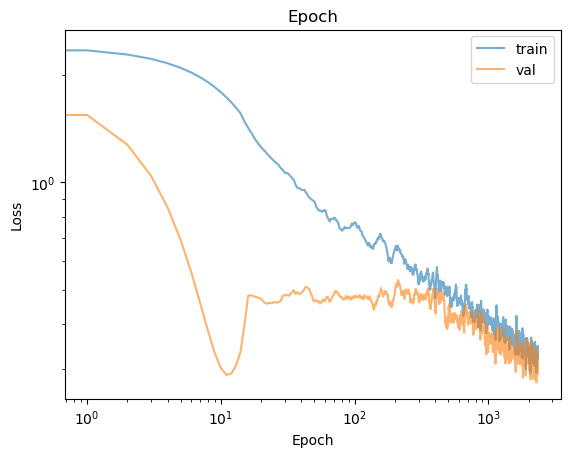

In [99]:
from scipy.signal import savgol_filter

# Plot loss
plt.plot(savgol_filter(model.train_losses, 30, 3), label="train",alpha=0.6)
plt.plot(savgol_filter(model.val_losses, 30, 3), label="val",alpha=0.6)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch")
plt.yscale("log")
plt.xscale("log")

plt.legend()

In [100]:
# get a batch of data from the test set
data = next(iter(test_loader))
data[0].shape

torch.Size([128, 1, 28, 28])

In [107]:
cpt = !ls -t nn_results/*
cpt = cpt[0]
print(cpt)

# Load up the model class
model = mycnn.load_from_checkpoint(cpt).to(device)
model.eval()  # Set the model to evaluation mode

# Example input data, replace with your actual data
example_input = data[0].to(device)

# Get predictions
with torch.no_grad():  # Disable gradient calculation
    predictions = model(example_input)

# If you want the class with the highest probability
predicted_class = torch.argmax(predictions, dim=1)

print(predicted_class)

nn_results/datalab_nn_pytorch_2024-11-12T21:39.ckpt
tensor([8, 9, 4, 0, 3, 6, 4, 5, 4, 8, 0, 8, 9, 0, 2, 2, 9, 3, 6, 3, 8, 7, 4, 4,
        0, 4, 4, 2, 7, 1, 5, 0, 5, 3, 3, 7, 3, 4, 6, 1, 4, 6, 9, 0, 0, 5, 6, 7,
        7, 2, 5, 6, 2, 4, 1, 4, 9, 8, 3, 4, 5, 5, 6, 3, 5, 8, 5, 9, 8, 1, 2, 8,
        1, 3, 6, 8, 3, 4, 2, 5, 3, 2, 6, 8, 1, 2, 7, 3, 6, 4, 6, 5, 0, 1, 7, 3,
        7, 8, 4, 1, 8, 5, 0, 5, 3, 0, 8, 5, 6, 1, 0, 7, 6, 1, 9, 7, 2, 9, 3, 3,
        2, 6, 0, 6, 3, 6, 3, 5], device='mps:0')


In [108]:
data[1] # these are the real labels

tensor([2, 9, 6, 0, 3, 4, 4, 5, 4, 8, 0, 8, 9, 0, 2, 2, 9, 3, 3, 3, 8, 7, 4, 4,
        0, 4, 4, 8, 7, 1, 5, 0, 5, 3, 2, 7, 3, 4, 2, 1, 6, 0, 9, 6, 0, 5, 6, 7,
        7, 2, 5, 2, 2, 4, 1, 4, 9, 8, 3, 4, 5, 5, 6, 3, 5, 8, 5, 9, 8, 1, 2, 8,
        1, 3, 6, 8, 3, 4, 2, 5, 0, 2, 6, 8, 1, 2, 7, 6, 6, 4, 6, 5, 0, 1, 7, 3,
        5, 8, 4, 3, 8, 5, 0, 5, 3, 0, 8, 5, 6, 1, 0, 7, 6, 1, 9, 7, 6, 9, 3, 3,
        2, 6, 0, 6, 3, 6, 3, 5])

In [118]:
test_set.labels

array([0, 1, 2, ..., 8, 8, 1])

Text(0.5, -3.2833333333333368, 'Predicted label')

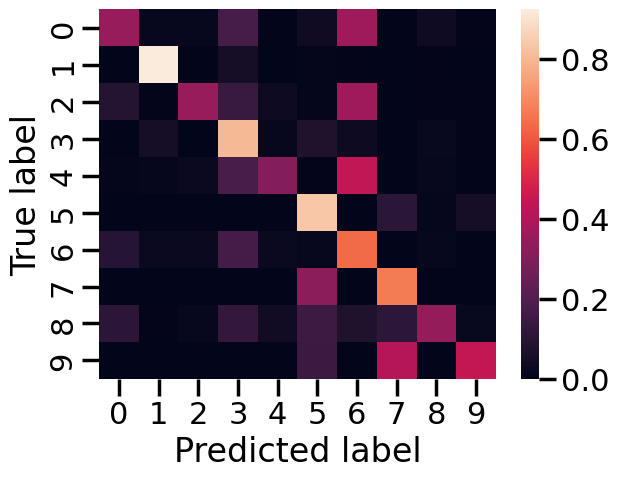

In [121]:
all_test = torch.permute(torch.Tensor(test_set.images), (0, 3, 1, 2))
with torch.no_grad():  # Disable gradient calculation
    predictions = model(all_test.to(device))
predicted_class = torch.argmax(predictions, dim=1)

conf_mat = confusion_matrix(test_set.labels, predicted_class.cpu())

import seaborn as sns
sns.set_context("poster")
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [122]:
conf_mat

array([[347,  17,  16, 170,   2,  37, 366,   2,  36,   7],
       [  0, 923,   0,  52,   1,   9,   6,   0,   7,   2],
       [ 89,   6, 349, 139,  31,   9, 366,   1,   6,   4],
       [  1,  52,   0, 802,  17,  74,  29,   0,  19,   6],
       [  9,  14,  26, 180, 309,   7, 438,   0,  15,   2],
       [  0,   0,   0,   0,   0, 833,   0, 103,  12,  52],
       [ 91,  23,  22, 169,  23,  17, 636,   1,  16,   2],
       [  0,   0,   0,   0,   0, 327,   0, 670,   1,   2],
       [107,   7,  18, 124,  42, 151,  75, 111, 346,  19],
       [  0,   0,   0,   0,   0, 143,   0, 414,   0, 443]])

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [123]:
lookup = {0: "T-shirt/top",
          1: "Trouser",
          2: "Pullover",
          3: "Dress",
          4: "Coat",
          5: "Sandal",
          6: "Shirt",
          7: "Sneaker",
          8: "Bag",
          9: "Ankle boot"}

In [133]:
ind_wrong = []
for i, (pred, actual) in enumerate(zip(predicted_class.cpu(),test_set.labels)):
    if pred != actual:
        ind_wrong.append((i, pred.item(), actual))

In [134]:
ind_wrong[1]

(3, 6, 2)

Text(0.5, 1.0, 'pred=Dress true=Coat')

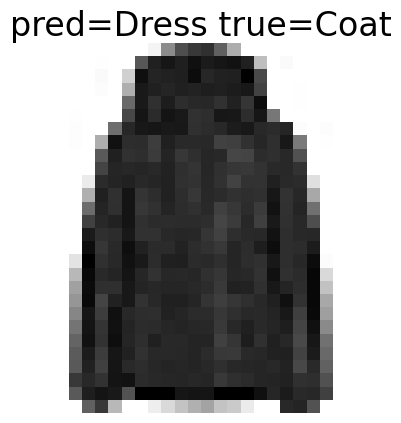

In [137]:
ind = 10
plt.imshow(all_test[ind_wrong[ind][0]][0,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.axis("off")
plt.title(f"pred={lookup[ind_wrong[ind][1]]} true={lookup[ind_wrong[ind][2]]}")

### Aside: Dropout 

You'll notice above that the `accuracy` is much higher than the `val_accuracy`. That is, we overfit on the training data. One way to help protect against this is to introduce `Dropout`

<img src="https://cdn-images-1.medium.com/max/1600/1*iWQzxhVlvadk6VAJjsgXgg.png">

Srivastava, Nitish, et al. ”Dropout: a simple way to prevent neural networks from
overfitting”, JMLR 2014

```python
        x = self.layer3(x)
        # Flatten
        x = x.view(x.size(0), -1)
        x = nn.Dropout(p=0.25)(x) # drop 25% 
        x=torch.relu(self.fc1(x))
```

### Aside: Visualization of the layers

From François Chollet (“DEEP LEARNING with Python”):

Intermediate activations are “useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.”

“The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts. Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network. Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.”

Following from https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

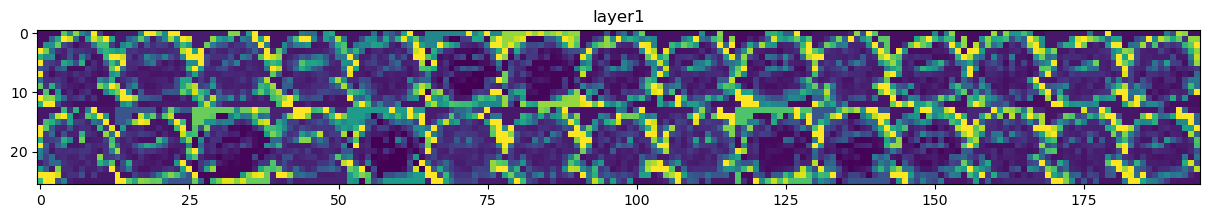

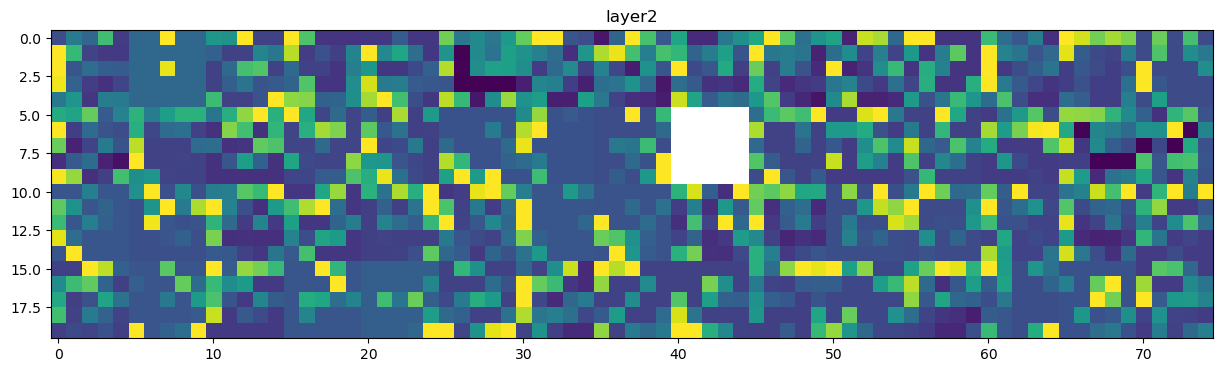

In [57]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

data, _ = next(iter(train_set))
data.unsqueeze_(0)

for layer_name, layer in [('layer1', model.layer1), 
                          ('layer2', model.layer2)]:
    layer.register_forward_hook(get_activation(layer_name))
    output = model(data)

    layer_activation = activation[layer_name].squeeze()

    images_per_row = 15
    n_features = layer_activation.shape[0]   # Number of features in the feature map
    size = layer_activation.shape[1] # The feature map has shape (n_features, size, size).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[col * images_per_row + row,
                                              :, :]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255)
            display_grid[col * size : (col + 1) * size, # Displays the grid
                          row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
acti

# Data Augmentation

Another way to avoid overfitting, aside from `Dropout`, is to increase the number of exmaples used to to train the model.  Data augmentation is a generic term for methods used to expand the effect training set size by generating more data from the original training set. In images, this is pretty natural: scale changes, rotations, flips, etc. should still give us the same label. This method has the benefit of usually increasing test-time accuracy.

<img src="https://cdn-images-1.medium.com/max/1200/1*C8hNiOqur4OJyEZmC7OnzQ.png">

In Pytorch see https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html and https://pytorch.org/vision/stable/transforms.html

In [54]:
train_transforms = transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.RandomAffine(degrees=15, shear=0.1),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
])

train_set = FashionDataset(train_csv, transform=train_transforms)
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2)

'Pullover'

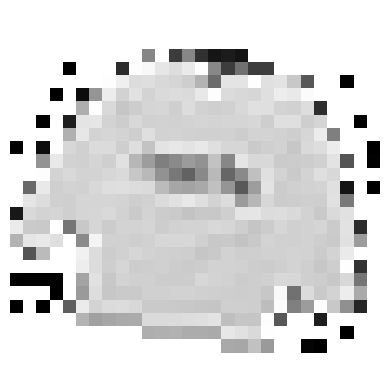

In [55]:
image, label = next(iter(train_set))
plt.axis('off')

plt.imshow(image.squeeze(), cmap=plt.cm.gray_r, interpolation='nearest')
output_label(label)

In [56]:
class mycnn_dropout(pl.LightningModule):

    def __init__(self):
        super().__init__()

        # set this to an example input size to the see a summary
        # see https://pytorch-lightning.readthedocs.io/en/latest/common/debugging.html
        self._example_input_array = torch.randn((1, 1, 28, 28))

        # define the layers here
        # Conv2d(in_channels, out_channels, kernel_size)
        # see https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            
            # see https://github.com/sksq96/pytorch-summary/issues/55#issuecomment-471844028
            # to understand why pytorch and keras differ here
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.1)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
        )
        
        self.fc1=torch.nn.Linear(1152, 32)
        self.fc2=torch.nn.Linear(32, 10)
    
        self.loss = nn.NLLLoss()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # add dropout 
        x = nn.Dropout(p=0.2)(x)

        x=torch.relu(self.fc1(x))
        x=F.log_softmax(self.fc2(x), dim=-1)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.75,
            patience=2,
            min_lr=1e-6,
            verbose=True
        )
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_accuracy"}
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def _evaluate(self, batch, batch_idx, stage=None):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=-1)
        acc = accuracy(preds, y, task="multiclass", num_classes=nb_classes)

        if stage:
            self.log(f'{stage}_loss', loss, prog_bar=True)
            self.log(f'{stage}_accuracy', acc, prog_bar=True)

        return loss, acc
    
    def validation_step(self, batch, batch_idx):
        return self._evaluate(batch, batch_idx, 'val')[0]
    
    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return test_loader

In [ ]:
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
filename = f'datalab_nn_pytorch_dropout_{run_time_string}'

early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.001,
   patience=3,
   verbose=True,
   mode='max'
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    dirpath='nn_results',
    filename=filename,
    verbose=True,
    save_top_k=1
)

logger = [CSVLogger("nn_results1", name=filename), TensorBoardLogger("nn_results", name=filename)]

pl.seed_everything(42)

if device == "gpu":
    myTrainer=pl.Trainer(callbacks=[early_stop_callback, checkpoint_callback], logger=logger,
                     gpus=-1, accelerator='dp', auto_select_gpus=True, max_epochs=5)
else:
    myTrainer=pl.Trainer(callbacks=[early_stop_callback, checkpoint_callback], logger=logger,
                         max_epochs=5)
    
model_dropout=mycnn_dropout()
myTrainer.fit(model_dropout)